<a href="https://colab.research.google.com/github/UranMai/Others/blob/master/Movie_reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FILES PREPARATION



> Create dataframes with reviews, sentiment and rating



In [1]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
import tarfile
import numpy as np
import pandas as pd
import os
import re
import nltk

In [3]:
path = '/content/drive/My Drive/movies_reviews/aclImdb_v1.tar.gz'
tar = tarfile.open(path)
tar.extractall() #extract to dir aclImdb
tar.close()

In [4]:
def data_preparation():
  """
  Prepare movie dataframes of review, sentiment and rating
  """
  
  data = {}
  PATH = '/content/aclImdb'
  for split in ['train', 'test']:
    data[split] = []
    for sentiment in ['pos', 'neg']:
      if sentiment == 'pos':
        score = 1
      else: 
        score = 0

      path = os.path.join(PATH, split, sentiment)
      filenames = os.listdir(path)
      
      for name in filenames:
        ratings = re.findall(r'_(.*?).txt', name)
        ratings = ''.join(ratings)
        with open(os.path.join(path, name), "r") as f:
          review = f.read()
          data[split].append([review, score, int(ratings)])

  np.random.shuffle(data["train"])        
  data["train"] = pd.DataFrame(data["train"], columns=['text', 'sentiment', 'rating'])
  data["train"].to_csv("train_data.csv")
  np.random.shuffle(data["test"])
  data["test"] = pd.DataFrame(data["test"], columns=['text', 'sentiment', 'rating'])
  data["test"].to_csv("test_data.csv")
  return data["train"], data["test"]

In [5]:
train_data, test_data = data_preparation()

In [20]:
train_data.head()

,text,sentiment,rating
0,saw vancouver international film festival funn...,1,9
1,hilariously accurate caricature trying sell sc...,1,8
2,quirky independent theatrical christian slater...,0,3
3,ever wanted eat worm s documentary show yeah k...,0,3
4,tell spent making waste time ugh anything remo...,0,1


In [21]:
test_data.head()

,text,sentiment,rating
0,relatively young nt knowNEG badNEG antisemitis...,1,9
1,bought movie market stall three year ago got t...,0,1
2,despite absolutely horrid script later film st...,0,3
3,unfortunately littleknown film say unfortunate...,1,10
4,thomas hardy one favorite author truly wonderf...,0,1


# EDA 



> We need to pay attention to negation words (like don't, isnot,etc.) which is a part of stopwords. Because in that task it is important to define negative words for prediction negative polarity.


> I define separately the list of negation words and the list of stopwords





In [6]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')[:143] + ['ma', 'won', 's']
stop_words.remove("don")
stop_words.remove("don't")
#print(stop_words)
negation_words = stopwords.words('english')[143:] + ["don", "don't"]
negation_words.remove('ma')
negation_words.remove('won')
#print(negation_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
import string #punctuation list
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer, word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.sentiment.util import mark_negation
nltk.download('punkt')
from bs4 import BeautifulSoup

def delete_htmls(text):
    soup = BeautifulSoup(text, 'lxml')
    clean_text = soup.get_text()
    return clean_text

def add_spaces(text):
    """
    There some cases w/o spaces between words and dots, commas
    Add spaces after dots and commas
    """
    proc_text = re.sub(r'(?<=[.,!?])(?=[^\s])', ' ', text)
    return proc_text

def remove_numbers(text):
    clean_text = re.sub(r'\d+', '', text)
    return clean_text

def remove_punc(text): 
    clean_text = [''.join(sym for sym in txt if sym not in string.punctuation) for txt in text]
    text = [symb for symb in clean_text if symb]
    return text

def removestopwords(text):
    words = [w for w in text if w not in stop_words]
    return words

def negation_text(text):
    negated_text = mark_negation(text)
    return negated_text


def processing(text):
    new_text = remove_numbers(add_spaces(delete_htmls(text)))
    new_text = ' '.join(new_text.split())
    token_text = word_tokenize(new_text)
    proc_text = negation_text(removestopwords(token_text))
    clean_text = remove_punc(proc_text)
    return clean_text

[nltk_data] Downloading package punkt to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


[nltk_data]   Package punkt is already up-to-date!


In [8]:
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
def lemmatizing(tokens):
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)


from nltk.stem import PorterStemmer
stemmer = PorterStemmer()
def stemming(tokens):
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(stemmed_tokens)

def func(text):
    txt = ' '.join(text)
    return txt

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
train_data['text'] = train_data['text'].str.lower()
test_data['text'] = test_data['text'].str.lower()
train_data['text'] = train_data['text'].apply(processing)
test_data['text'] = test_data['text'].apply(processing)

In [10]:
train_data['text'] = train_data['text'].apply(lemmatizing)
test_data['text'] = test_data['text'].apply(lemmatizing)
# train_data['text'] = train_data['text'].apply(stemming)
# test_data['text'] = test_data['text'].apply(stemming)

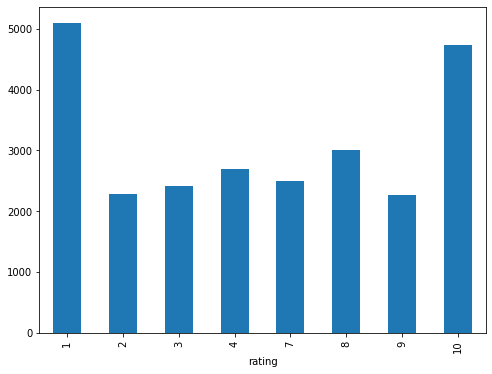

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
train_data.groupby('rating').text.count().plot.bar(ylim=0)
plt.show()

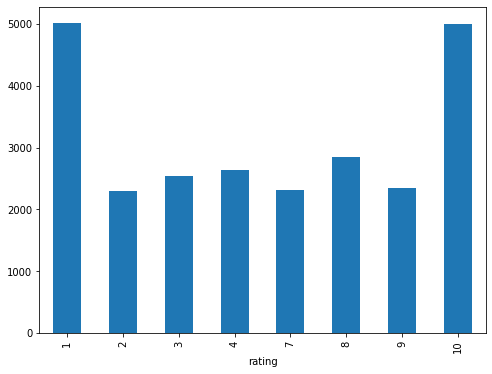

In [15]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
test_data.groupby('rating').text.count().plot.bar(ylim=0)
plt.show()

In [11]:
df_train = train_data.drop(train_data[train_data.rating == 1][:2700].index)
df_train = df_train.drop(df_train[df_train.rating == 10][:2400].index)
df_train = df_train.drop(df_train[df_train.rating == 8][:700].index)
df_train = df_train.drop(df_train[df_train.rating == 4][:300].index)
df_train.rating.value_counts()

7     2496
3     2420
1     2400
4     2396
10    2332
8     2309
2     2284
9     2263
Name: rating, dtype: int64

In [12]:
df_test = test_data.drop(test_data[test_data.rating == 1][:2700].index)
df_test = df_test.drop(df_test[df_test.rating == 10][:2700].index)
df_test = df_test.drop(df_test[df_test.rating == 8][:500].index)
df_test = df_test.drop(df_test[df_test.rating == 4][:300].index)
df_test = df_test.drop(df_test[df_test.rating == 3][:200].index)

df_test.rating.value_counts()

8     2350
9     2344
3     2341
4     2335
1     2322
7     2307
2     2302
10    2299
Name: rating, dtype: int64

# SENTIMENT PREDICTION

In [75]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score, accuracy_score

#X_train, X_valid, y_train, y_valid = train_test_split(train_data['text'], train_data['sentiment'], test_size=0.2)
X_train, y_train = train_data['text'], train_data['sentiment']
X_test, y_test = test_data['text'], test_data['sentiment']

vec = CountVectorizer(ngram_range=(1,3), binary=True)

X_train = vec.fit_transform(X_train)
X_test = vec.transform(X_test)

In [76]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

for c in [0.01, 0.05, 0.1]:
    model = LinearSVC(C=c)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print("Model is {}".format(model))
    print("The F1 accuracy score: {}%".format(f1_score(y_test, pred) * 100))
    print("Accuracy score is {}%".format(accuracy_score(y_test, pred) * 100))
    print(50*'-', sep='\n')


Model is LinearSVC(C=0.01, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
The F1 accuracy score: 88.71917263325379%
Accuracy score is 88.656%
--------------------------------------------------
Model is LinearSVC(C=0.05, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
The F1 accuracy score: 88.58440213494781%
Accuracy score is 88.536%
--------------------------------------------------
Model is LinearSVC(C=0.1, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
The F1 accuracy score: 88.54457101887995%
A

In [77]:
for c in [0.5, 0.1, 1]:
    model = LogisticRegression(C=c)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    print("Model is {}".format(model))
    print("The F1 accuracy score: {}%".format(f1_score(y_test, pred) * 100))
    print("Accuracy score is {}%".format(accuracy_score(y_test, pred) * 100))
    print(50*'-', sep='\n')

Model is LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
The F1 accuracy score: 88.73250636132313%
Accuracy score is 88.664%
--------------------------------------------------
Model is LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
The F1 accuracy score: 88.52589324748618%
Accuracy score is 88.452%
--------------------------------------------------
Model is LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
        

**FINAL MODEL** 

In [80]:
model = LogisticRegression(C=1)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print("Model is {}".format(model))
print("The F1 accuracy score: {}%".format(f1_score(y_test, pred) * 100))
print("Accuracy score is {}%".format(accuracy_score(y_test, pred) * 100))

Model is LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
The F1 accuracy score: 88.73603435251083%
Accuracy score is 88.668%


**Pickle models for web app**


In [ ]:
import pickle

with open("model", 'wb') as mdl:
  pickle.dump(model, mdl)

with open("stopwords", 'wb') as word:
  pickle.dump(stop_words, word)

with open("vectorizer", 'wb') as vect:
  pickle.dump(vec, vect)

# RATING PREDICTION

In [13]:
X_train, y_train = df_train['text'], df_train['rating']
X_test, y_test = df_test['text'], df_test['rating']


In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.model_selection import cross_val_score


nb = Pipeline([('vect', CountVectorizer(ngram_range=(1,3), binary=True)),
               ('tfidf', TfidfTransformer()),
               ('clf', LinearSVC()),
              ])
nb.fit(X_train, y_train)

from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.34096774193548385
              precision    recall  f1-score   support

           1       0.40      0.72      0.52      2322
           2       0.26      0.14      0.18      2302
           3       0.29      0.23      0.26      2341
           4       0.34      0.26      0.29      2335
           7       0.32      0.43      0.37      2307
           8       0.27      0.15      0.19      2350
           9       0.28      0.22      0.25      2344
          10       0.40      0.59      0.47      2299

    accuracy                           0.34     18600
   macro avg       0.32      0.34      0.32     18600
weighted avg       0.32      0.34      0.32     18600



In [63]:
import pickle
import joblib
import bz2

with open("model", 'wb') as mdl:
  pickle.dump(nb, mdl)